In [46]:
%matplotlib inline 

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from utils import processed, load, denormalize, get_normalized_adj, generate_dataset

In [47]:
class Temporal_Layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel):
        super(Temporal_Layer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel))
        
    def forward(self, x):
        x = x.permute(0,3,1,2).type(torch.cuda.FloatTensor)
        normal = self.conv1(x)
        sig = torch.sigmoid(self.conv2(x))
        out = normal * sig
        out = out.permute(0,2,3,1)
        # Convert back from NCHW to NHWC
        return out
        
        
class Stgcn_Block(nn.Module):
    def __init__(self, in_channels, spatial_channels, out_channels, nodes_num):
        super(Stgcn_Block, self).__init__()
        self.temporal_layer1 = Temporal_Layer(in_channels, out_channels, kernel = 2) 
        self.temporal_layer2 = Temporal_Layer(in_channels = spatial_channels, out_channels = out_channels, kernel = 2)
        
        self.weight = nn.Parameter(torch.FloatTensor(out_channels, spatial_channels)) 
        self.initialise_weight()
        
        self.batch_norm = nn.BatchNorm2d(nodes_num)
        
        
    def initialise_weight(self):
        std_dv = 1. / math.sqrt(self.weight.shape[1])
        self.weight.data.uniform_(-std_dv, std_dv)
        
    def forward(self, x, adj_hat):
        # First temporal Block
        temporal_block1 = self.temporal_layer1(x)
        
        #Spatial Graph Convolution
        t = temporal_block1.permute(1,0,2,3) #Converts tensor from nhwc to hnwc for multiplication with adj_matrix
        t = t.type(torch.cuda.DoubleTensor)
        gconv1 = torch.einsum("ij, jklm -> kilm", [adj_hat, t]) #(h,h) * (h,n,w,c) -> (n,h,w,c)
        gconv2 = F.relu(torch.matmul(gconv1, self.weight.double()))
        
        #Second Temporal Block
        temporal_block2 = self.temporal_layer2(gconv2) 
        
        out = self.batch_norm(temporal_block2)
        return out

class Stgcn_Model(nn.Module):
    def __init__(self, nodes_num, features_num, input_timesteps, num_output):
        super(Stgcn_Model, self).__init__()
        self.stgcn_block1 = Stgcn_Block(in_channels = features_num, spatial_channels = 16, out_channels = 64,
                                       nodes_num = nodes_num)
        
        self.stgcn_block2 = Stgcn_Block(in_channels = 64, spatial_channels = 16,  out_channels = 64,
                                       nodes_num = nodes_num)
        
        self.temporal_layer = Temporal_Layer(in_channels = 64, out_channels = 64, kernel = 2)
        self.fc = nn.Linear((input_timesteps * 106) * 64, num_output)

    def forward(self, adj_hat, x):
        out1 = self.stgcn_block1(x, adj_hat)
        out2 = self.stgcn_block2(out1, adj_hat)
        out3 = self.temporal_layer(out2)
        #out3_temp = out3.reshape((out3.shape[0], out3.shape[1], -1)) #reshaped to torch.Size([12, 53, 64])
        out3_temp = out3.reshape(-1,40704)
        out4 = self.fc(out3_temp) 
        return out4

In [48]:
def train(x_input, x_target, batch_size):
    num_samples = x_input.shape[0]
    shuffled_order = torch.randperm(num_samples)
    
    training_loss = []
    for i in range(math.ceil(num_samples / batch_size)):
        stgcn.train()
        optimizer.zero_grad()
        
        start = i * batch_size
        batch = shuffled_order[start:start+batch_size]
        
        #Drop left-overs
        if len(batch) % batch_size != 0:
            continue
        
        x_batch = x_input[batch].to(device = device)
        y_batch = x_target[batch].to(device = device)
        
        
        out = stgcn(adj_mat, x_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.detach().cpu().numpy())
        
    return sum(training_loss) / len(training_loss)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
batch_size = 12

num_timesteps_input = 6 # 30 minutes
num_timesteps_output = 2 # 10 minutes

In [50]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

# overwrite = False means that the processing function will only run if the process data files do not exist
# overwrite = True => functions will run regardless
processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, means, stds = load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

# input shape (num_samples ,num_vertices, num_timesteps_window, num_features)
# output shape (num_samples ,num_vertices, num_timesteps_window)
adj_mat = get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).to(device)

In [51]:
def validate(val_input, val_target, batch_size):
    num_samples = val_input.shape[0]
    shuffled_order = torch.randperm(num_samples)
    total_val_loss = 0
    counter = 0
    for i in range(math.ceil(num_samples / batch_size)):
        start = i * batch_size
        batch = shuffled_order[start:start+batch_size]
        
        #Drop left-overs
        if len(batch) % batch_size != 0:
            continue
        
        val_input_batch = val_input[batch].to(device = device)
        val_target_batch = val_target[batch].to(device = device)
        out = stgcn(adj_mat, val_input_batch)
        val_loss = loss_criterion(out, val_target_batch).to(device='cpu')
        total_val_loss += val_loss
        counter += 1
        
    total_val_loss = total_val_loss / counter
    return total_val_loss
    
    
    

In [55]:
def predict(x_input):
    num_samples = x_input.shape[0]
    results = []
    for i in range(math.ceil(num_samples/batch_size)):
        start = i * batch_size
        test_input = x_input[start: start+batch_size]
        if test_input.shape[0] % batch_size != 0:
            continue
        with torch.no_grad():
            stgcn.eval()
            out = stgcn(adj_mat, test_input)
            results.append(out)
    return results
    

In [52]:
stgcn = Stgcn_Model(nodes_num = adj_mat.shape[0], features_num = training_input.shape[3],
                    input_timesteps = num_timesteps_input, num_output = num_timesteps_output).to(device = device)

optimizer = torch.optim.Adam(stgcn.parameters(), lr = 0.01)
loss_criterion = nn.MSELoss()

training_loss = []
validation_loss = []

for epoch in range(epochs):
    loss = train(training_input, training_target, batch_size)
    training_loss.append(loss)

    with torch.no_grad():
        stgcn.eval()
        val_loss = validate(val_input, val_target, batch_size)
        validation_loss.append(val_loss.item())

    print("Training Loss: {}".format(loss))
    print("Validation Loss: {}".format(val_loss))




Training Loss: 98.47137179731685
Validation Loss: 2.1220011711120605
Training Loss: 1.4746126346090898
Validation Loss: 1.4187487363815308
Training Loss: 1.3029539020941219
Validation Loss: 1.1004555225372314
Training Loss: 1.3849110598551397
Validation Loss: 1.0937327146530151
Training Loss: 1.3473029186062635
Validation Loss: 1.1138156652450562
Training Loss: 1.2626813229392557
Validation Loss: 1.0558737516403198
Training Loss: 1.1610293525425508
Validation Loss: 1.1445482969284058
Training Loss: 1.1049487656131785
Validation Loss: 1.012089729309082
Training Loss: 1.1337344864791727
Validation Loss: 0.9852995872497559
Training Loss: 1.1181226514558742
Validation Loss: 1.0615489482879639
Training Loss: 1.110053054151688
Validation Loss: 0.9829967617988586
Training Loss: 1.0861274845459883
Validation Loss: 0.9814156293869019
Training Loss: 1.0435187614219075
Validation Loss: 0.9674597382545471
Training Loss: 1.0548877370230016
Validation Loss: 0.9961093664169312
Training Loss: 1.035848

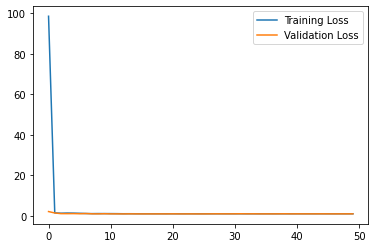

In [53]:

plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [54]:
with torch.no_grad():
    stgcn.eval()
    test_loss = validate(test_input, test_target, batch_size)
    print(test_loss)

tensor(0.9389)


In [56]:
results = predict(test_input)

In [63]:
print(denormalize(results, stds[0], means[0]))

[[[tensor([[4.0647, 4.0624]], device='cuda:0')
   tensor([[4.0647, 4.0624]], device='cuda:0')
   tensor([[4.0649, 4.0625]], device='cuda:0')
   tensor([[4.0648, 4.0624]], device='cuda:0')
   tensor([[4.0650, 4.0626]], device='cuda:0')
   tensor([[4.0650, 4.0625]], device='cuda:0')
   tensor([[4.0653, 4.0628]], device='cuda:0')
   tensor([[4.0648, 4.0623]], device='cuda:0')
   tensor([[4.0644, 4.0625]], device='cuda:0')
   tensor([[4.0640, 4.0624]], device='cuda:0')
   tensor([[4.0647, 4.0622]], device='cuda:0')
   tensor([[4.0650, 4.0627]], device='cuda:0')
   tensor([[4.0647, 4.0623]], device='cuda:0')
   tensor([[4.0649, 4.0625]], device='cuda:0')
   tensor([[4.0646, 4.0622]], device='cuda:0')
   tensor([[4.0648, 4.0624]], device='cuda:0')
   tensor([[4.0647, 4.0623]], device='cuda:0')
   tensor([[4.0647, 4.0623]], device='cuda:0')
   tensor([[4.0647, 4.0624]], device='cuda:0')
   tensor([[4.0646, 4.0623]], device='cuda:0')
   tensor([[4.0645, 4.0622]], device='cuda:0')
   tensor([[4

In [62]:
print(denormalize(test_target, stds[0], means[0]))

tensor([[[3., 3.],
         [3., 3.],
         [4., 4.],
         ...,
         [5., 5.],
         [3., 3.],
         [5., 5.]],

        [[3., 3.],
         [3., 3.],
         [4., 4.],
         ...,
         [5., 5.],
         [3., 3.],
         [5., 5.]],

        [[3., 3.],
         [3., 3.],
         [4., 4.],
         ...,
         [5., 4.],
         [3., 3.],
         [5., 4.]],

        ...,

        [[4., 3.],
         [4., 4.],
         [5., 5.],
         ...,
         [5., 5.],
         [4., 4.],
         [6., 5.]],

        [[3., 4.],
         [4., 4.],
         [5., 5.],
         ...,
         [5., 4.],
         [4., 4.],
         [5., 4.]],

        [[4., 4.],
         [4., 4.],
         [5., 5.],
         ...,
         [4., 3.],
         [4., 3.],
         [4., 4.]]])
